In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'casia-20-image-tampering-detection-dataset' dataset.
Path to dataset files: /kaggle/input/casia-20-image-tampering-detection-dataset


In [ ]:
import os

base_dir = os.path.join(path, "CASIA2")
print("Isi subfolder CASIA2:")
print(os.listdir(base_dir))


Isi subfolder CASIA2:
['CASIA 2 Groundtruth', 'Au', 'Tp']


In [ ]:
folders = ["Au", "Tp", "CASIA 2 Groundtruth"]
for folder in folders:
    full_path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(full_path))} file")


Au: 7492 file
Tp: 5125 file
CASIA 2 Groundtruth: 5123 file


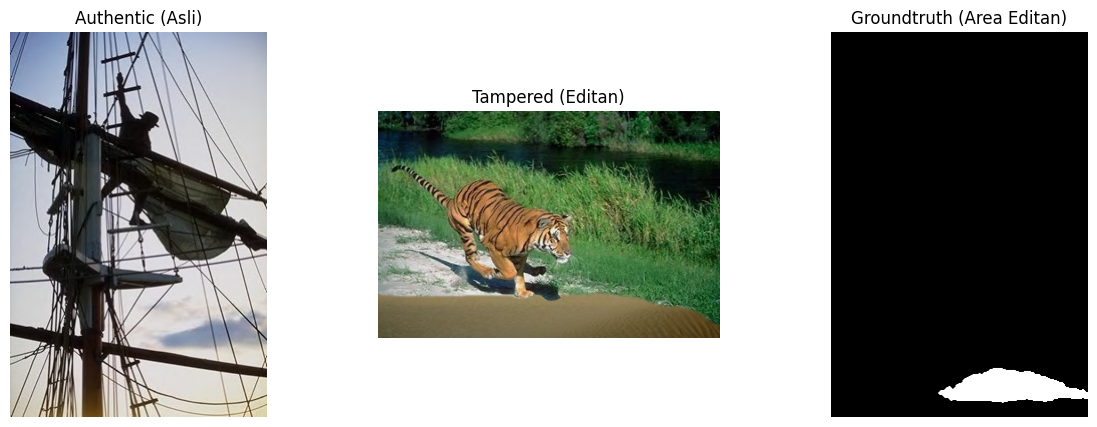

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

# ambil file random dari tiap folder
sample_auth = random.choice(os.listdir(os.path.join(base_dir, "Au")))
sample_tamp = random.choice(os.listdir(os.path.join(base_dir, "Tp")))
sample_mask = random.choice(os.listdir(os.path.join(base_dir, "CASIA 2 Groundtruth")))

# load gambar
img_auth = cv2.imread(os.path.join(base_dir, "Au", sample_auth))
img_tamp = cv2.imread(os.path.join(base_dir, "Tp", sample_tamp))
img_mask = cv2.imread(os.path.join(base_dir, "CASIA 2 Groundtruth", sample_mask), cv2.IMREAD_GRAYSCALE)

# ubah warna BGR ke RGB untuk matplotlib
img_auth = cv2.cvtColor(img_auth, cv2.COLOR_BGR2RGB)
img_tamp = cv2.cvtColor(img_tamp, cv2.COLOR_BGR2RGB)

# tampilkan
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_auth)
plt.title("Authentic (Asli)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_tamp)
plt.title("Tampered (Editan)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_mask, cmap='gray')
plt.title("Groundtruth (Area Editan)")
plt.axis('off')

plt.show()


In [ ]:
import cv2
sizes = []
folder_path = os.path.join(base_dir, "Au")
for f in random.sample(os.listdir(folder_path), 50):  # ambil 50 sample acak
    img = cv2.imread(os.path.join(folder_path, f))
    if img is not None:
        sizes.append(img.shape[:2])  # (height, width)

sizes_df = pd.DataFrame(sizes, columns=['height', 'width'])
print(sizes_df.describe())


           height       width
count   50.000000   50.000000
mean   318.800000  382.980000
std    120.913361  113.281749
min    240.000000  160.000000
25%    256.000000  384.000000
50%    256.000000  384.000000
75%    384.000000  384.000000
max    780.000000  800.000000


In [ ]:
# Melihat jenis ekstensi file di folder Tp
tp_folder = os.path.join(base_dir, "Tp")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Tp:")
print(ext_count)


Jenis ekstensi file di folder Tp:
.tif    3059
.jpg    2064
.txt       1
.db        1
Name: count, dtype: int64


In [ ]:
# Melihat jenis ekstensi file di folder Au
tp_folder = os.path.join(base_dir, "Au")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Au:")
print(ext_count)


Jenis ekstensi file di folder Au:
.jpg    7437
.bmp      54
.db        1
Name: count, dtype: int64


In [ ]:
# Melihat jenis ekstensi file di folder CASIA 2 Groundtruth
tp_folder = os.path.join(base_dir, "CASIA 2 Groundtruth")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder CASIA 2 Groundtruth:")
print(ext_count)


Jenis ekstensi file di folder CASIA 2 Groundtruth:
.png    5123
Name: count, dtype: int64


In [ ]:
import sys
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import shutil
import math

# ---------- CONFIG ----------
# Jika base_dir sudah ada di namespace (dari cell sebelumnya), gunakan; kalau tidak, pakai fallback common Kaggle path
if 'base_dir' in globals():
    BASE_DIR = Path(base_dir)
else:
    BASE_DIR = Path("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2")

FOLDERS = ["Au", "Tp", "CASIA 2 Groundtruth"]
VALID_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
MOVE_INVALID = False   # ubah ke True jika ingin memindahkan file invalid ke folder invalid_files
INVALID_ROOT = BASE_DIR / "invalid_files"  # jika MOVE_INVALID True, file akan dipindahkan ke sini
MANIFEST_CSV = "casia_manifest.csv"  # nama file manifest yang dibuat di working dir

# ---------- helper ----------
def file_size_bytes(p: Path) -> int:
    try:
        return p.stat().st_size
    except Exception:
        return -1

def try_open_image(p: Path):
    """Return (ok, width, height). ok=False jika gagal buka atau bukan image."""
    try:
        with Image.open(p) as img:
            img.verify()  # verify quick check
        # reopen to get size after verify (some formats need re-open)
        with Image.open(p) as img:
            w, h = img.size
        return True, w, h
    except (UnidentifiedImageError, OSError, ValueError):
        return False, None, None

# ---------- scan ----------
rows = []
for folder in FOLDERS:
    folder_path = BASE_DIR / folder
    if not folder_path.exists():
        print(f"[WARN] Folder not found: {folder_path}")
        continue
    # iterate
    for entry in os.scandir(folder_path):
        if not entry.is_file():
            continue
        p = Path(entry.path)
        ext = p.suffix.lower()
        is_ext_image = ext in VALID_EXT
        fsize = file_size_bytes(p)
        can_open, width, height = (False, None, None)
        if is_ext_image:
            can_open, width, height = try_open_image(p)
        rows.append({
            "folder": folder,
            "filename": p.name,
            "filepath": str(p),
            "ext": ext,
            "is_ext_image": is_ext_image,
            "can_open": can_open,
            "width": width,
            "height": height,
            "filesize_bytes": fsize
        })

# ---------- manifest ----------
df = pd.DataFrame(rows)
# summary counts
print("Summary ekstensi (overall):")
print(df['ext'].value_counts())
print("\nJumlah file total per folder (sebelum cleaning):")
print(df['folder'].value_counts())

# identify invalid files:
# invalid = not image-ext OR image-ext but cannot open
df['valid'] = df['is_ext_image'] & df['can_open']

print("\nCounts by valid flag:")
print(df['valid'].value_counts(dropna=False))

# show a sample of invalid
invalid_df = df[~df['valid']].copy()
print(f"\nContoh file invalid (max 20): {len(invalid_df)} found")
display(invalid_df.head(20))

# save manifest csv
df.to_csv(MANIFEST_CSV, index=False)
print(f"\nManifest saved to: {MANIFEST_CSV} (rows: {len(df)})")

# ---------- optional: move invalid files ----------
if MOVE_INVALID and len(invalid_df)>0:
    print("\nMemindahkan file invalid ke folder:", INVALID_ROOT)
    for _, r in invalid_df.iterrows():
        src = Path(r['filepath'])
        dest_dir = INVALID_ROOT / r['folder']
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest = dest_dir / src.name
        try:
            shutil.move(str(src), str(dest))
        except Exception as e:
            print("Failed to move", src, "->", dest, ":", e)
    print("Pemindahan selesai. (Periksa folder invalid_files)")

# ---------- counts after cleaning (if we were to only consider valid) ----------
valid_counts = df[df['valid']==True].groupby('folder').size().rename('valid_count')
total_counts = df.groupby('folder').size().rename('total_count')
summary = pd.concat([total_counts, valid_counts], axis=1).fillna(0).astype(int)
summary['invalid_count'] = summary['total_count'] - summary['valid_count']
print("\nRingkasan sebelum/sesudah (per folder):")
display(summary)

# ---------- optional: save lists of valid files per folder ----------
for folder in FOLDERS:
    out_csv = f"valid_files_{folder.replace(' ','_')}.csv"
    df_valid = df[(df['folder']==folder) & (df['valid']==True)].copy()
    df_valid.to_csv(out_csv, index=False)
    print(f"Saved {len(df_valid)} valid file entries for '{folder}' to {out_csv}")

print("\nSelesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.")


Summary ekstensi (overall):
ext
.jpg    9501
.png    5123
.tif    3059
.bmp      54
.db        2
.txt       1
Name: count, dtype: int64

Jumlah file total per folder (sebelum cleaning):
folder
Au                     7492
Tp                     5125
CASIA 2 Groundtruth    5123
Name: count, dtype: int64

Counts by valid flag:
valid
True     17737
False        3
Name: count, dtype: int64

Contoh file invalid (max 20): 3 found


,folder,filename,filepath,ext,is_ext_image,can_open,width,height,filesize_bytes,valid
4965,Au,Thumbs.db,/kaggle/input/casia-20-image-tampering-detecti...,.db,False,False,NaN,NaN,77312,False
10545,Tp,_list.txt,/kaggle/input/casia-20-image-tampering-detecti...,.txt,False,False,NaN,NaN,215175,False
10924,Tp,Thumbs.db,/kaggle/input/casia-20-image-tampering-detecti...,.db,False,False,NaN,NaN,32768,False



Manifest saved to: casia_manifest.csv (rows: 17740)

Ringkasan sebelum/sesudah (per folder):


,total_count,valid_count,invalid_count
folder,,,
Au,7492,7491,1
CASIA 2 Groundtruth,5123,5123,0
Tp,5125,5123,2


Saved 7491 valid file entries for 'Au' to valid_files_Au.csv
Saved 5123 valid file entries for 'Tp' to valid_files_Tp.csv
Saved 5123 valid file entries for 'CASIA 2 Groundtruth' to valid_files_CASIA_2_Groundtruth.csv

Selesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.


In [ ]:
# Cell: split_dataset.ipynb
from sklearn.model_selection import train_test_split

random.seed(42)

BASE_DIR = Path(base_dir)  # pakai base_dir yang sudah kamu miliki
OUT_DIR = Path("casia_split")  # hasil split akan disimpan di sini
OUT_DIR.mkdir(exist_ok=True)

# load valid file lists (yang tadi disimpan)
df_au = pd.read_csv("valid_files_Au.csv")
df_tp = pd.read_csv("valid_files_Tp.csv")

# buat label kolom
df_au['label'] = 'authentic'
df_tp['label'] = 'tampered'
df_all = pd.concat([df_au, df_tp], ignore_index=True)

# kita gunakan filename saja (kolom 'filename' dan folder)
# split stratified berdasarkan label
train_val, test = train_test_split(df_all, test_size=0.15, stratify=df_all['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1764706, stratify=train_val['label'], random_state=42)
# 0.1764706 * 85% ≈ 15% (so overall 70/15/15)

print("Counts:", "train", len(train), "val", len(val), "test", len(test))
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic', 'tampered']:
        c = (df_split['label']==lbl).sum()
        print(f"{split_name} {lbl}: {c}")

# create folders and copy files (or you can create symlink)
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic','tampered']:
        target_dir = OUT_DIR / split_name / lbl
        target_dir.mkdir(parents=True, exist_ok=True)
    for _, row in df_split.iterrows():
        src = Path(row['filepath'])  # path lengkap
        dst = OUT_DIR / split_name / row['label'] / src.name
        if not dst.exists():
            shutil.copy(src, dst)  # atau shutil.copy2 to retain metadata

print("Split and copy done. Inspect casia_split/ folder.")


Counts: train 8829 val 1892 test 1893
train authentic: 5243
train tampered: 3586
val authentic: 1124
val tampered: 768
test authentic: 1124
test tampered: 769
Split and copy done. Inspect casia_split/ folder.


In [ ]:
from tqdm.notebook import tqdm

IN_TEST_DIR = Path("casia_split/test")
OUT_DEG_DIR = Path("casia_split/test_degraded")
OUT_DEG_DIR.mkdir(exist_ok=True)

# parameters
TARGET_SIZE = (224,224)
JPEG_QUALITIES = [90, 70, 40]          # compression levels
GAUSSIAN_NOISE_SIGMA = [5, 15, 30]     # standard deviation
GAUSSIAN_BLUR_K = [3,5,9]              # kernel sizes (odd)
DOWNSCALE_FACTORS = [0.5, 0.25]        # downscale then upsample

def preprocess_and_save(img, outpath):
    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(str(outpath), img_resized)

def add_gaussian_noise(img, sigma):
    img_f = img.astype(np.float32)
    noise = np.random.normal(0, sigma, img_f.shape).astype(np.float32)
    out = img_f + noise
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def add_gaussian_blur(img, k):
    return cv2.GaussianBlur(img, (k,k), 0)

def jpeg_compress(img, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    is_success, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def down_upscale(img, factor):
    h,w = img.shape[:2]
    new_h, new_w = max(1,int(h*factor)), max(1,int(w*factor))
    small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    up = cv2.resize(small, (w,h), interpolation=cv2.INTER_LINEAR)
    return up

def occlude_random_block(img, block_frac=0.2):
    h,w = img.shape[:2]
    bh = int(h*block_frac); bw = int(w*block_frac)
    x = np.random.randint(0,w-bw+1)
    y = np.random.randint(0,h-bh+1)
    img2 = img.copy()
    img2[y:y+bh, x:x+bw] = 0  # black occlusion; bisa juga pake blur or patch
    return img2

# iterate test set, create degraded versions
for label in ['authentic','tampered']:
    src_dir = IN_TEST_DIR / label
    for p in tqdm(list(src_dir.glob('*'))[:1000], desc=f"processing {label}"):  # batasi dulu, hilangkan slicing untuk semua
        img = cv2.imread(str(p))
        if img is None:
            continue
        # baseline preprocessed save
        base_out = OUT_DEG_DIR / 'clean' / label
        base_out.mkdir(parents=True, exist_ok=True)
        preprocess_and_save(img, base_out / p.name)

        # JPEG qualities
        for q in JPEG_QUALITIES:
            outdir = OUT_DEG_DIR / f'jpeg_q{q}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_j = cv2.resize(img, TARGET_SIZE)
            img_j = jpeg_compress(img_j, q)
            cv2.imwrite(str(outdir / p.name), img_j)

        # Gaussian noise
        for s in GAUSSIAN_NOISE_SIGMA:
            outdir = OUT_DEG_DIR / f'gn_sigma{s}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_n = preprocess_and_save(add_gaussian_noise(img, s), outdir / p.name)

        # Gaussian blur
        for k in GAUSSIAN_BLUR_K:
            outdir = OUT_DEG_DIR / f'gb_k{k}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_b = add_gaussian_blur(cv2.resize(img, TARGET_SIZE), k)
            cv2.imwrite(str(outdir / p.name), img_b)

        # downscale
        for fct in DOWNSCALE_FACTORS:
            outdir = OUT_DEG_DIR / f'down_{int(fct*100)}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_d = down_upscale(img, fct)
            cv2.imwrite(str(outdir / p.name), cv2.resize(img_d, TARGET_SIZE))

        # occlusion
        outdir = OUT_DEG_DIR / 'occlusion' / label
        outdir.mkdir(parents=True, exist_ok=True)
        img_oc = occlude_random_block(cv2.resize(img, TARGET_SIZE), block_frac=0.25)
        cv2.imwrite(str(outdir / p.name), img_oc)

print("Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)")


processing authentic:   0%|          | 0/1000 [00:00<?, ?it/s]

processing tampered:   0%|          | 0/769 [00:00<?, ?it/s]

Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128
BATCH_SIZE = 32
Z_DIM = 100
EPOCHS = 5  # bisa dinaikkan kalau kuat
SAVE_DIR = Path("gan_lightweight")
SAVE_DIR.mkdir(exist_ok=True)

print("Device:", DEVICE)

Device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder(root="casia_split/train", transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*8, 4, 1, 0, bias=False), # Adjusted first layer input channels
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g*2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False), # Keep kernel=4, stride=2
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False), # Keep kernel=4, stride=2
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d*2, 1, 4, 1, 0, bias=False), # Keep kernel=4, stride=1, padding=0
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

In [ ]:
gen = Generator(Z_DIM).to(DEVICE)
disc = Discriminator().to(DEVICE)
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
print("🚀 Training DCGAN ...")
fixed_noise = torch.randn(16, Z_DIM, 1, 1).to(DEVICE)

for epoch in range(EPOCHS):
    for real, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        real = real.to(DEVICE)
        bs = real.size(0)

        # ----- Train Discriminator -----
        noise = torch.randn(bs, Z_DIM, 1, 1, device=DEVICE)
        fake = gen(noise)

        disc_real = disc(real)
        disc_fake = disc(fake.detach())

        # 🔹 samakan ukuran label dengan output disc
        label_real = torch.ones_like(disc_real)
        label_fake = torch.zeros_like(disc_fake)

        lossD_real = criterion(disc_real, label_real)
        lossD_fake = criterion(disc_fake, label_fake)
        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # ----- Train Generator -----
        output = disc(fake)
        label_gen = torch.ones_like(output)  # generator ingin disc percaya "real"
        lossG = criterion(output, label_gen)

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    # 🔹 Simpan sampel hasil tiap epoch
    with torch.no_grad():
        fake_sample = gen(fixed_noise)
        save_image(fake_sample * 0.5 + 0.5, SAVE_DIR / f"sample_epoch{epoch+1}.png", nrow=4)
    print(f"[Epoch {epoch+1}] LossD={lossD:.4f} | LossG={lossG:.4f}")

print("✅ Training DCGAN selesai.")


🚀 Training DCGAN ...


Epoch 1/5: 100%|██████████| 276/276 [03:15<00:00,  1.41it/s]


[Epoch 1] LossD=0.6325 | LossG=0.8619


Epoch 2/5: 100%|██████████| 276/276 [02:48<00:00,  1.64it/s]


[Epoch 2] LossD=0.5608 | LossG=0.9244


Epoch 3/5: 100%|██████████| 276/276 [02:50<00:00,  1.62it/s]


[Epoch 3] LossD=0.3480 | LossG=1.3962


Epoch 4/5: 100%|██████████| 276/276 [03:00<00:00,  1.53it/s]


[Epoch 4] LossD=0.2318 | LossG=1.8238


Epoch 5/5: 100%|██████████| 276/276 [02:52<00:00,  1.60it/s]

[Epoch 5] LossD=0.1788 | LossG=2.2672
✅ Training DCGAN selesai.


In [ ]:
gen.eval()
disc.eval()

with torch.no_grad():
    # generate contoh tampered baru
    z = torch.randn(4, Z_DIM, 1, 1).to(DEVICE)
    fake_imgs = gen(z)
    preds = disc(fake_imgs)
    print("Prediksi Discriminator (0=fake, 1=real):", preds.cpu().numpy())
    save_image(fake_imgs * 0.5 + 0.5, SAVE_DIR / "final_generated.png", nrow=4)

print("📦 Semua hasil disimpan di folder:", SAVE_DIR)

Prediksi Discriminator (0=fake, 1=real): [[0.40556088]
 [0.19005854]
 [0.18192224]
 [0.16076148]
 [0.09540532]
 [0.40415123]
 [0.2974672 ]
 [0.2575615 ]
 [0.10569126]
 [0.08836837]
 [0.41999298]
 [0.3620231 ]
 [0.32009104]
 [0.16148248]
 [0.2724763 ]
 [0.35475415]
 [0.35854924]
 [0.43670774]
 [0.29519635]
 [0.4522034 ]
 [0.19292617]
 [0.33560386]
 [0.50767034]
 [0.47518063]
 [0.22761169]
 [0.44688925]
 [0.2169924 ]
 [0.21120292]
 [0.19474639]
 [0.1000068 ]
 [0.41532665]
 [0.32586467]
 [0.29047516]
 [0.13725045]
 [0.10416722]
 [0.42926353]
 [0.3878205 ]
 [0.3222469 ]
 [0.18910597]
 [0.29307327]
 [0.3478992 ]
 [0.38484994]
 [0.43101305]
 [0.3043516 ]
 [0.43160218]
 [0.165562  ]
 [0.3287556 ]
 [0.46534362]
 [0.48024085]
 [0.19013238]
 [0.39735857]
 [0.1984452 ]
 [0.18773654]
 [0.17833048]
 [0.09341868]
 [0.35125622]
 [0.3204499 ]
 [0.26456705]
 [0.12619947]
 [0.09498528]
 [0.3941381 ]
 [0.41803417]
 [0.31993577]
 [0.1792679 ]
 [0.28525022]
 [0.36545688]
 [0.41304895]
 [0.4450393 ]
 [0.301

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


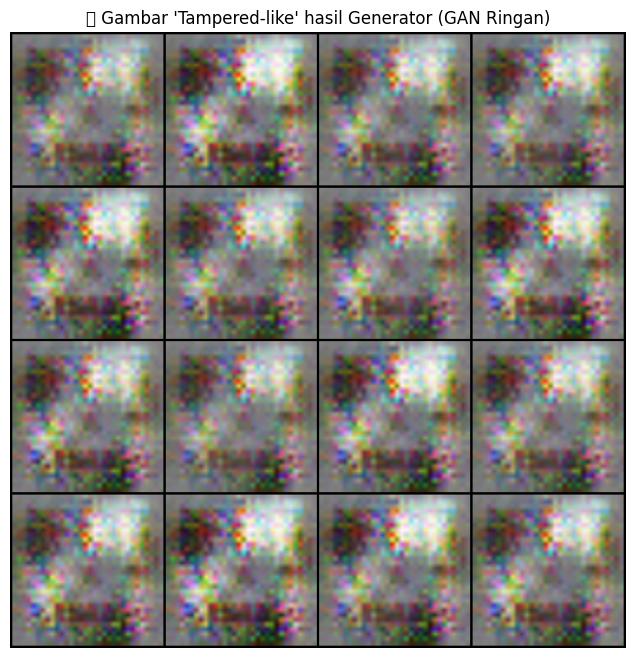

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


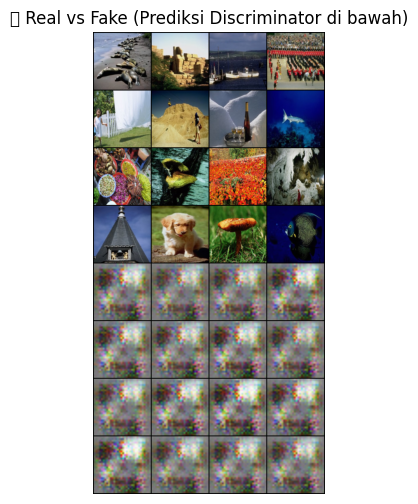

Total samples ditampilkan: 32
Real             → Discriminator Score: 0.480
Real             → Discriminator Score: 0.607
Real             → Discriminator Score: 0.610
Real             → Discriminator Score: 0.641
Real             → Discriminator Score: 0.627
Real             → Discriminator Score: 0.558
Real             → Discriminator Score: 0.572
Real             → Discriminator Score: 0.522
Real             → Discriminator Score: 0.563
Real             → Discriminator Score: 0.649
Real             → Discriminator Score: 0.659
Real             → Discriminator Score: 0.689
Real             → Discriminator Score: 0.732
Real             → Discriminator Score: 0.757
Real             → Discriminator Score: 0.770
Real             → Discriminator Score: 0.726
Fake (Generated) → Discriminator Score: 0.500
Fake (Generated) → Discriminator Score: 0.547
Fake (Generated) → Discriminator Score: 0.474
Fake (Generated) → Discriminator Score: 0.674
Fake (Generated) → Discriminator Score: 0.583
Fake

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import random, os
from pathlib import Path

# -------------- 1️⃣ Tampilkan contoh hasil dari Generator --------------
gen.eval()
with torch.no_grad():
    z = torch.randn(16, Z_DIM, 1, 1).to(DEVICE)
    fake_imgs = gen(z)
    fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
    fake_imgs = (fake_imgs * 0.5 + 0.5).cpu()

grid = make_grid(fake_imgs, nrow=4)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title("🧩 Gambar 'Tampered-like' hasil Generator (GAN Ringan)")
plt.show()

# -------------- 2️⃣ Evaluasi kemampuan Discriminator --------------
real_imgs = []
real_paths = random.sample(list((Path("casia_split/train/authentic")).glob("*.jpg")), 16)
for p in real_paths:
    img = Image.open(p).convert("RGB")
    img = transforms.Resize((IMG_SIZE, IMG_SIZE))(img)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize([0.5]*3, [0.5]*3)(img)
    real_imgs.append(img)

real_imgs = torch.stack(real_imgs).to(DEVICE)

fake_imgs = gen(torch.randn(16, Z_DIM, 1, 1).to(DEVICE))
fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

# Gabungkan & beri label
all_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
labels = ["Real"] * 16 + ["Fake (Generated)"] * 16

disc.eval()
with torch.no_grad():
    preds = disc(all_imgs).view(-1).cpu().numpy()

# -------------- 3️⃣ Visualisasi hasil Discriminator --------------
imgs_show = (all_imgs * 0.5 + 0.5).cpu()
grid = make_grid(imgs_show, nrow=4)
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title("🎯 Real vs Fake (Prediksi Discriminator di bawah)")
plt.show()

# Pastikan jumlah label sama dengan output prediksi
min_len = min(len(labels), len(preds))
print(f"Total samples ditampilkan: {min_len}")

for i in range(min_len):
    print(f"{labels[i]:<16} → Discriminator Score: {preds[i]:.3f}")



In [ ]:
from torchvision.utils import save_image
from pathlib import Path
from tqdm.notebook import tqdm

OUT_TP_GAN = Path("casia_split/train_gan/tampered")
OUT_TP_GAN.mkdir(parents=True, exist_ok=True)

gen.eval()
with torch.no_grad():
    for i in tqdm(range(1000), desc="Generate tampered-like images (GAN)"):
        z = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        fake = gen(z)
        fake = torch.nn.functional.interpolate(fake, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        fake = (fake * 0.5 + 0.5).clamp(0,1)
        save_image(fake, OUT_TP_GAN / f"tampered_gan_{i:04d}.png")

print("📦 Generated tampered-like images saved to:", OUT_TP_GAN)


Generate tampered-like images (GAN):   0%|          | 0/1000 [00:00<?, ?it/s]

📦 Generated tampered-like images saved to: casia_split/train_gan/tampered


In [ ]:
import shutil

combined_root = Path("casia_split/train_gan_combined")
for lbl in ["authentic", "tampered"]:
    (combined_root / lbl).mkdir(parents=True, exist_ok=True)

# Salin dataset asli
!cp -r casia_split/train/authentic/* casia_split/train_gan_combined/authentic/
!cp -r casia_split/train/tampered/* casia_split/train_gan_combined/tampered/

# Tambahkan hasil GAN
!cp -r casia_split/train_gan/tampered/* casia_split/train_gan_combined/tampered/

print("✅ Dataset kombinasi siap di folder:", combined_root)


✅ Dataset kombinasi siap di folder: casia_split/train_gan_combined


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm.notebook import tqdm

# Transform
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(root="casia_split/train_gan_combined", transform=train_transforms)
val_ds = datasets.ImageFolder(root="casia_split/val", transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# ResNet50
def get_resnet50(num_classes=2):
    model = models.resnet50(weights='IMAGENET1K_V1')
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_f, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return model.to(DEVICE)

model_gan = get_resnet50(2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gan.parameters(), lr=1e-4)

# Training loop
EPOCHS = 5
best_f1 = 0
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

for ep in range(1, EPOCHS+1):
    model_gan.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Train Ep{ep}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model_gan(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Ep {ep} | Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model_gan.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = torch.argmax(model_gan(xb), 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f"🔹 Val Acc={acc:.4f} | F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model_gan.state_dict(), f"resnet50_gan_best_f1{best_f1:.4f}.pth")
        print("✅ Best model updated")

print(f"\n🏁 Selesai. Best F1 = {best_f1:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


Train Ep1:   0%|          | 0/308 [00:00<?, ?it/s]

Ep 1 | Train Loss: 0.4934
🔹 Val Acc=0.7748 | F1=0.7723
✅ Best model updated


Train Ep2:   0%|          | 0/308 [00:00<?, ?it/s]

In [ ]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

# ======== 1️⃣ Load Model Terbaik ========
model_gan = get_resnet50(2)
best_model_path = sorted(Path(".").glob("resnet50_gan_best_f1*.pth"))[-1]  # otomatis ambil yang terbaru
print("📦 Loading model:", best_model_path.name)
model_gan.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model_gan.to(DEVICE).eval()

# ======== 2️⃣ Helper Function ========
def evaluate(model, loader):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            preds = torch.argmax(out, 1)
            probs = torch.softmax(out, 1)[:, 1]
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

def compute_metrics(y_true, y_pred, y_prob):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        auc_val = roc_auc_score(y_true, y_prob)
    except:
        auc_val = np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_val}

# ======== 3️⃣ Test Clean Dataset ========
val_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_ds = datasets.ImageFolder("casia_split/test", transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

y_t, p_t, prob_t = evaluate(model_gan, test_loader)
m_clean = compute_metrics(y_t, p_t, prob_t)
print("✅ Test (Clean) Results:", m_clean)

# ======== 4️⃣ Evaluate Semua Test_Degraded Variants ========
deg_root = Path("casia_split/test_degraded")
results = {"clean": m_clean}

for variant_dir in sorted([d for d in deg_root.iterdir() if d.is_dir()]):
    ds = datasets.ImageFolder(str(variant_dir), transform=val_transforms)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    yv, pv, pr = evaluate(model_gan, loader)
    results[variant_dir.name] = compute_metrics(yv, pv, pr)
    print(f"{variant_dir.name}: {results[variant_dir.name]}")

# Simpan hasil ke CSV
pd.DataFrame(results).T.to_csv("resnet50_gan_eval_results.csv", index=True)
print("\n📊 Semua hasil disimpan ke: resnet50_gan_eval_results.csv")


In [ ]:
# ---------- 1️⃣ Bar Chart per Variant ----------
def plot_metrics_bar(results, metrics=['acc','f1','auc'], figsize=(10,5)):
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index':'variant'})
    df_melt = df.melt(id_vars='variant', value_vars=metrics, var_name='metric', value_name='value')
    plt.figure(figsize=figsize)
    sns.barplot(data=df_melt, x='variant', y='value', hue='metric')
    plt.xticks(rotation=45, ha='right')
    plt.title('Performa per Variant (Test Degraded)')
    plt.tight_layout()
    plt.show()

plot_metrics_bar(results)

# ---------- 2️⃣ Confusion Matrix ----------
cm = confusion_matrix(y_t, p_t)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📊 Confusion Matrix ResNet50 + GAN (Test Clean)")
plt.show()

# ---------- 3️⃣ ROC & PR Curves ----------
fpr, tpr, _ = roc_curve(y_t, prob_t)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_t, prob_t)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, color='green')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()


In [ ]:
def plot_perf_vs_degrad(results, metric='f1', kind='jpeg'):
    rows = []
    import re
    for k,v in results.items():
        if kind in k:
            nums = re.findall(r'\d+', k)
            val = float(nums[-1]) if nums else np.nan
            rows.append({'variant':k, 'param':val, metric: v.get(metric, np.nan)})
    if not rows:
        print("No variants found for kind =", kind)
        return
    df = pd.DataFrame(rows).sort_values('param', ascending=(kind!='jpeg'))
    plt.figure(figsize=(8,4))
    plt.plot(df['param'], df[metric], '-o')
    plt.xlabel(kind + ' parameter'); plt.ylabel(metric)
    plt.title(f'{metric.upper()} vs {kind}')
    plt.grid(True)
    plt.show()

plot_perf_vs_degrad(results, metric='f1', kind='jpeg')
plot_perf_vs_degrad(results, metric='f1', kind='gn')
